# TREINO COM FLATTEN E DATASET IMAGEM 64x64x3 CROSS VALIDATION CALLBACKS

In [1]:
#Import libraries
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, Rescaling, BatchNormalization, Conv2D, MaxPooling2D, SpatialDropout2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint
from numpy import load
from tensorboard import version
from keras.preprocessing import image
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import os, datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.datasets
import gc

In [2]:
#Import and check tensorflow version

print(tf.__version__)

#check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

print("tensorboard.version.VERSION: ", version.VERSION)

2.10.1
Num GPUs Available:  0
Num GPUs Available:  0
tensorboard.version.VERSION:  2.10.1


In [3]:
directory='../Images/64x64'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    label_mode='int',
    seed=1337,
    image_size=(64,64),
    batch_size= None,
)

Found 16621 files belonging to 5 classes.


In [4]:
image_array = []
label_array = []

for element in train_ds:  

    image_array.append(np.asarray(element[0]))
    label_array.append(np.asarray(element[1]))

image_array = np.asarray(image_array)
label_array = np.asarray(label_array)

print(image_array.shape)
print(label_array.shape)

(16621, 64, 64, 3)
(16621,)


In [5]:
x_train, x_test, y_train, y_test = train_test_split(image_array, label_array, test_size=0.1, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(14958, 64, 64, 3)
(14958,)
(1663, 64, 64, 3)
(1663,)


## MODELO

In [6]:
gc.collect()

# Define per-fold score containers
acc_eval_per_fold = []
loss_eval_per_fold = []
acc_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_score_per_fold = []
cm_score_per_fold = []
history_cv = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
with tf.device("/cpu:0"):
    for train, test in kfold.split(x_train,y_train):
                
        model = Sequential()
        ##normalizaçao [-1,1]
        model.add(Rescaling(1./127.5, offset=-1, input_shape=(64, 64, 3)))
        model.add(Conv2D(filters=128, kernel_size=(2), strides=(1), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2), padding='valid', strides=(1)))
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))
        model.add(Dense(5,activation='softmax'))
        
        model.compile(
            optimizer='adam',
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

        #Saved models path
        model_name = 'conv2D_crossVal_64x64'
        save_path_best_model = '../Models/CrossValidation/Conv2D_64x64/' + model_name + '_fold_' + str(fold_no) +'.hdf5'

        # CREATE CALLBACKS
        checkpoint_val_acc = tf.keras.callbacks.ModelCheckpoint(save_path_best_model, 
                                                        monitor='val_accuracy', verbose=0, 
                                                        save_best_only=True, mode='max')

        callbacks_list = [checkpoint_val_acc]

        # Generate a print
        print('--------------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')


        # Fit data to model - uses x_train to train and validate
        history = model.fit(x_train[train], y_train[train],validation_data=(x_train[test], y_train[test]), 
                            verbose=2, batch_size=160, callbacks=callbacks_list, epochs=50)

        gc.collect()

        #load best model from fold
        best_model = load_model(save_path_best_model)

        # Generate generalization metrics - uses x_test to validate and predict
        scores = best_model.evaluate(x_train[test], y_train[test], verbose=0)

        # Calculate predicted labels for the test set
        y_pred = np.argmax(best_model.predict(x_test), axis=-1)

        # Calculate precision, recall, and F1 score
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)

        print(f'Score for fold {fold_no}: {best_model.metrics_names[0]} of {round(scores[0],5)}; {best_model.metrics_names[1]} of {round(scores[1]*100,5)}%')

        # Append scores to the corresponding lists
        acc_eval_per_fold.append(scores[1] * 100)
        loss_eval_per_fold.append(scores[0])

        acc_per_fold.append(accuracy*100)
        precision_per_fold.append(precision*100)
        recall_per_fold.append(recall*100)
        f1_score_per_fold.append(f1*100)
        cm_score_per_fold.append(cm)

        # Increase fold number
        fold_no = fold_no + 1

        gc.collect()

--------------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
85/85 - 74s - loss: 5.6059 - accuracy: 0.7259 - val_loss: 0.3849 - val_accuracy: 0.8763 - 74s/epoch - 866ms/step
Epoch 2/50
85/85 - 71s - loss: 0.2989 - accuracy: 0.9115 - val_loss: 0.2840 - val_accuracy: 0.9124 - 71s/epoch - 838ms/step
Epoch 3/50
85/85 - 71s - loss: 0.2020 - accuracy: 0.9392 - val_loss: 0.2537 - val_accuracy: 0.9184 - 71s/epoch - 840ms/step
Epoch 4/50
85/85 - 71s - loss: 0.1454 - accuracy: 0.9560 - val_loss: 0.2352 - val_accuracy: 0.9278 - 71s/epoch - 840ms/step
Epoch 5/50
85/85 - 72s - loss: 0.0979 - accuracy: 0.9730 - val_loss: 0.2371 - val_accuracy: 0.9338 - 72s/epoch - 844ms/step
Epoch 6/50
85/85 - 69s - loss: 0.0630 - accuracy: 0.9849 - val_loss: 0.2463 - val_accuracy: 0.9271 - 69s/epoch - 816ms/step
Epoch 7/50
85/85 - 71s - loss: 0.0422 - accuracy: 0.9928 - val_loss: 0.2564 - val_accuracy: 0.9311 - 71s/epoch - 835ms/step
Epoch 8/50
85/85 - 73s - lo

Epoch 15/50
85/85 - 73s - loss: 0.0186 - accuracy: 0.9973 - val_loss: 0.3892 - val_accuracy: 0.9057 - 73s/epoch - 855ms/step
Epoch 16/50
85/85 - 75s - loss: 0.0162 - accuracy: 0.9978 - val_loss: 0.3366 - val_accuracy: 0.9298 - 75s/epoch - 886ms/step
Epoch 17/50
85/85 - 73s - loss: 0.0176 - accuracy: 0.9975 - val_loss: 0.3509 - val_accuracy: 0.9238 - 73s/epoch - 855ms/step
Epoch 18/50
85/85 - 73s - loss: 0.0177 - accuracy: 0.9979 - val_loss: 0.3711 - val_accuracy: 0.9111 - 73s/epoch - 856ms/step
Epoch 19/50
85/85 - 73s - loss: 0.0236 - accuracy: 0.9966 - val_loss: 0.3614 - val_accuracy: 0.9231 - 73s/epoch - 856ms/step
Epoch 20/50
85/85 - 72s - loss: 0.0137 - accuracy: 0.9981 - val_loss: 0.3441 - val_accuracy: 0.9245 - 72s/epoch - 852ms/step
Epoch 21/50
85/85 - 73s - loss: 0.0117 - accuracy: 0.9982 - val_loss: 0.3430 - val_accuracy: 0.9285 - 73s/epoch - 855ms/step
Epoch 22/50
85/85 - 73s - loss: 0.0121 - accuracy: 0.9982 - val_loss: 0.3448 - val_accuracy: 0.9278 - 73s/epoch - 863ms/step


Epoch 29/50
85/85 - 72s - loss: 0.0131 - accuracy: 0.9980 - val_loss: 0.3045 - val_accuracy: 0.9385 - 72s/epoch - 850ms/step
Epoch 30/50
85/85 - 73s - loss: 0.0127 - accuracy: 0.9981 - val_loss: 0.3031 - val_accuracy: 0.9352 - 73s/epoch - 853ms/step
Epoch 31/50
85/85 - 72s - loss: 0.0129 - accuracy: 0.9978 - val_loss: 0.3011 - val_accuracy: 0.9392 - 72s/epoch - 850ms/step
Epoch 32/50
85/85 - 72s - loss: 0.0187 - accuracy: 0.9979 - val_loss: 0.3334 - val_accuracy: 0.9358 - 72s/epoch - 852ms/step
Epoch 33/50
85/85 - 72s - loss: 0.0113 - accuracy: 0.9978 - val_loss: 0.3094 - val_accuracy: 0.9372 - 72s/epoch - 852ms/step
Epoch 34/50
85/85 - 72s - loss: 0.0119 - accuracy: 0.9978 - val_loss: 0.2863 - val_accuracy: 0.9398 - 72s/epoch - 852ms/step
Epoch 35/50
85/85 - 72s - loss: 0.0088 - accuracy: 0.9978 - val_loss: 0.3235 - val_accuracy: 0.9365 - 72s/epoch - 850ms/step
Epoch 36/50
85/85 - 74s - loss: 0.0078 - accuracy: 0.9984 - val_loss: 0.3130 - val_accuracy: 0.9378 - 74s/epoch - 873ms/step


Epoch 43/50
85/85 - 74s - loss: 0.0071 - accuracy: 0.9989 - val_loss: 0.3535 - val_accuracy: 0.9305 - 74s/epoch - 875ms/step
Epoch 44/50
85/85 - 74s - loss: 0.0080 - accuracy: 0.9985 - val_loss: 0.3627 - val_accuracy: 0.9305 - 74s/epoch - 874ms/step
Epoch 45/50
85/85 - 74s - loss: 0.0086 - accuracy: 0.9981 - val_loss: 0.3570 - val_accuracy: 0.9325 - 74s/epoch - 875ms/step
Epoch 46/50
85/85 - 74s - loss: 0.0083 - accuracy: 0.9983 - val_loss: 0.3435 - val_accuracy: 0.9325 - 74s/epoch - 873ms/step
Epoch 47/50
85/85 - 75s - loss: 0.0076 - accuracy: 0.9985 - val_loss: 0.3664 - val_accuracy: 0.9318 - 75s/epoch - 877ms/step
Epoch 48/50
85/85 - 74s - loss: 0.0086 - accuracy: 0.9984 - val_loss: 0.3412 - val_accuracy: 0.9318 - 74s/epoch - 876ms/step
Epoch 49/50
85/85 - 74s - loss: 0.0057 - accuracy: 0.9987 - val_loss: 0.3626 - val_accuracy: 0.9318 - 74s/epoch - 875ms/step
Epoch 50/50
85/85 - 74s - loss: 0.0063 - accuracy: 0.9985 - val_loss: 0.3743 - val_accuracy: 0.9311 - 74s/epoch - 868ms/step


Epoch 6/50
85/85 - 79s - loss: 0.0700 - accuracy: 0.9811 - val_loss: 0.2430 - val_accuracy: 0.9298 - 79s/epoch - 924ms/step
Epoch 7/50
85/85 - 79s - loss: 0.0375 - accuracy: 0.9923 - val_loss: 0.3008 - val_accuracy: 0.9251 - 79s/epoch - 924ms/step
Epoch 8/50
85/85 - 81s - loss: 0.0254 - accuracy: 0.9955 - val_loss: 0.2774 - val_accuracy: 0.9372 - 81s/epoch - 947ms/step
Epoch 9/50
85/85 - 80s - loss: 0.0167 - accuracy: 0.9975 - val_loss: 0.2792 - val_accuracy: 0.9392 - 80s/epoch - 944ms/step
Epoch 10/50
85/85 - 77s - loss: 0.0131 - accuracy: 0.9978 - val_loss: 0.2867 - val_accuracy: 0.9352 - 77s/epoch - 909ms/step
Epoch 11/50
85/85 - 77s - loss: 0.0140 - accuracy: 0.9980 - val_loss: 0.3228 - val_accuracy: 0.9305 - 77s/epoch - 908ms/step
Epoch 12/50
85/85 - 77s - loss: 0.0156 - accuracy: 0.9975 - val_loss: 0.3582 - val_accuracy: 0.9205 - 77s/epoch - 909ms/step
Epoch 13/50
85/85 - 77s - loss: 0.0241 - accuracy: 0.9961 - val_loss: 0.3113 - val_accuracy: 0.9365 - 77s/epoch - 907ms/step
Epoc

Epoch 20/50
85/85 - 78s - loss: 0.0122 - accuracy: 0.9981 - val_loss: 0.3455 - val_accuracy: 0.9291 - 78s/epoch - 920ms/step
Epoch 21/50
85/85 - 78s - loss: 0.0104 - accuracy: 0.9983 - val_loss: 0.3663 - val_accuracy: 0.9231 - 78s/epoch - 920ms/step
Epoch 22/50
85/85 - 78s - loss: 0.0134 - accuracy: 0.9979 - val_loss: 0.3781 - val_accuracy: 0.9291 - 78s/epoch - 912ms/step
Epoch 23/50
85/85 - 78s - loss: 0.0154 - accuracy: 0.9978 - val_loss: 0.3539 - val_accuracy: 0.9251 - 78s/epoch - 914ms/step
Epoch 24/50
85/85 - 79s - loss: 0.0128 - accuracy: 0.9985 - val_loss: 0.3563 - val_accuracy: 0.9198 - 79s/epoch - 924ms/step
Epoch 25/50
85/85 - 79s - loss: 0.0102 - accuracy: 0.9983 - val_loss: 0.3709 - val_accuracy: 0.9225 - 79s/epoch - 928ms/step
Epoch 26/50
85/85 - 77s - loss: 0.0209 - accuracy: 0.9967 - val_loss: 0.3955 - val_accuracy: 0.9091 - 77s/epoch - 906ms/step
Epoch 27/50
85/85 - 76s - loss: 0.0201 - accuracy: 0.9980 - val_loss: 0.3487 - val_accuracy: 0.9245 - 76s/epoch - 895ms/step


Epoch 34/50
85/85 - 74s - loss: 0.0067 - accuracy: 0.9981 - val_loss: 0.3383 - val_accuracy: 0.9345 - 74s/epoch - 876ms/step
Epoch 35/50
85/85 - 75s - loss: 0.0073 - accuracy: 0.9987 - val_loss: 0.3231 - val_accuracy: 0.9291 - 75s/epoch - 878ms/step
Epoch 36/50
85/85 - 74s - loss: 0.0070 - accuracy: 0.9984 - val_loss: 0.3231 - val_accuracy: 0.9345 - 74s/epoch - 872ms/step
Epoch 37/50
85/85 - 74s - loss: 0.0074 - accuracy: 0.9985 - val_loss: 0.3326 - val_accuracy: 0.9372 - 74s/epoch - 875ms/step
Epoch 38/50
85/85 - 74s - loss: 0.0077 - accuracy: 0.9987 - val_loss: 0.3216 - val_accuracy: 0.9318 - 74s/epoch - 874ms/step
Epoch 39/50
85/85 - 77s - loss: 0.0083 - accuracy: 0.9984 - val_loss: 0.3054 - val_accuracy: 0.9385 - 77s/epoch - 910ms/step
Epoch 40/50
85/85 - 74s - loss: 0.0066 - accuracy: 0.9987 - val_loss: 0.3327 - val_accuracy: 0.9345 - 74s/epoch - 868ms/step
Epoch 41/50
85/85 - 74s - loss: 0.0090 - accuracy: 0.9984 - val_loss: 0.3204 - val_accuracy: 0.9325 - 74s/epoch - 873ms/step


Epoch 48/50
85/85 - 76s - loss: 0.0084 - accuracy: 0.9985 - val_loss: 0.3563 - val_accuracy: 0.9324 - 76s/epoch - 890ms/step
Epoch 49/50
85/85 - 76s - loss: 0.0069 - accuracy: 0.9987 - val_loss: 0.3734 - val_accuracy: 0.9311 - 76s/epoch - 891ms/step
Epoch 50/50
85/85 - 76s - loss: 0.0070 - accuracy: 0.9985 - val_loss: 0.3580 - val_accuracy: 0.9351 - 76s/epoch - 894ms/step
52/52 [==============================] - 5s 87ms/step
Score for fold 9: loss of 0.35425; accuracy of 93.64548%
--------------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/50
85/85 - 83s - loss: 4.0590 - accuracy: 0.7795 - val_loss: 0.3324 - val_accuracy: 0.9043 - 83s/epoch - 979ms/step
Epoch 2/50
85/85 - 80s - loss: 0.2503 - accuracy: 0.9222 - val_loss: 0.2758 - val_accuracy: 0.9171 - 80s/epoch - 942ms/step
Epoch 3/50
85/85 - 77s - loss: 0.1623 - accuracy: 0.9490 - val_loss: 0.2951 - val_accuracy: 0.9130 - 77s/epoch - 908ms/step
Epoch 4/50
85/85 - 80s - loss: 0.111

In [7]:
# Print the precision, recall, and F1 score for each fold, as well as the average scores
print('Score per fold')
for i in range(len(acc_eval_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} -  Eval Loss: {round(loss_eval_per_fold[i],5)} - Eval Accuracy: {round(acc_eval_per_fold[i],5)}% - Accuracy: {round(acc_per_fold[i],5)}% - Precision: {round(precision_per_fold[i],5)}% - Recall: {round(recall_per_fold[i],5)}% - F1 Score: {round(f1_score_per_fold[i],5)}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Evaluation Accuracy: {round(np.mean(acc_eval_per_fold),5)} (+- {round(np.std(acc_per_fold),5)})')
print(f'> Evaluation Loss: {round(np.mean(loss_eval_per_fold),5)}')
print(f'> Accuracy: {round(np.mean(acc_per_fold),5)} (+- {round(np.std(acc_per_fold),5)})')
print(f'> Precision: {round(np.mean(precision_per_fold),5)} (+- {round(np.std(precision_per_fold),5)})')
print(f'> Recall: {round(np.mean(recall_per_fold),5)} (+- {round(np.std(recall_per_fold),5)})')
print(f'> F1 Score: {round(np.mean(f1_score_per_fold),5)} (+- {round(np.std(f1_score_per_fold),5)})')
print('------------------------------------------------------------------------')

Score per fold
------------------------------------------------------------------------
> Fold 1 -  Eval Loss: 0.35599 - Eval Accuracy: 93.58289% - Accuracy: 93.80637% - Precision: 92.13543% - Recall: 92.43646% - F1 Score: 92.24226%
------------------------------------------------------------------------
> Fold 2 -  Eval Loss: 0.33656 - Eval Accuracy: 92.98128% - Accuracy: 93.26518% - Precision: 91.42136% - Recall: 91.74788% - F1 Score: 91.53195%
------------------------------------------------------------------------
> Fold 3 -  Eval Loss: 0.30492 - Eval Accuracy: 94.11765% - Accuracy: 93.44558% - Precision: 91.59113% - Recall: 92.60652% - F1 Score: 91.84805%
------------------------------------------------------------------------
> Fold 4 -  Eval Loss: 0.29899 - Eval Accuracy: 93.64973% - Accuracy: 93.20505% - Precision: 91.22983% - Recall: 92.02965% - F1 Score: 91.56799%
------------------------------------------------------------------------
> Fold 5 -  Eval Loss: 0.3 - Eval Accura

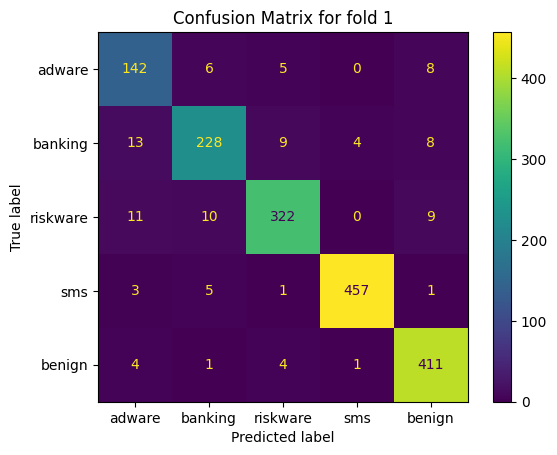

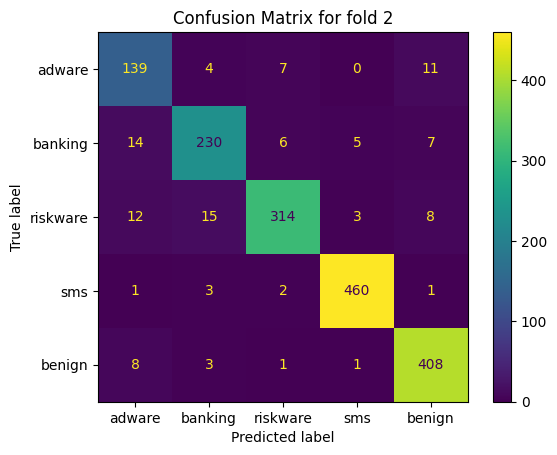

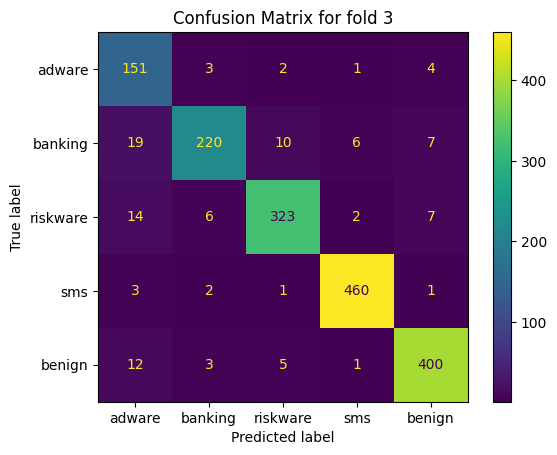

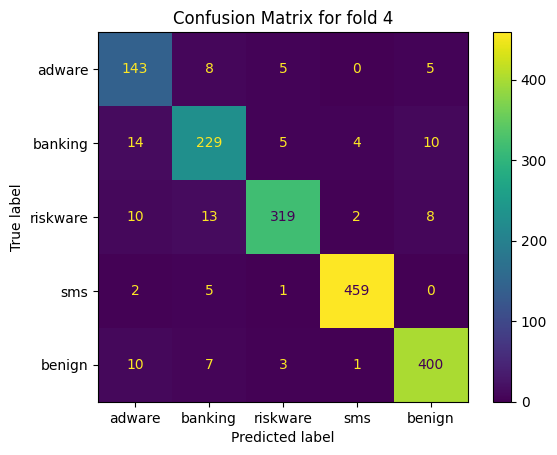

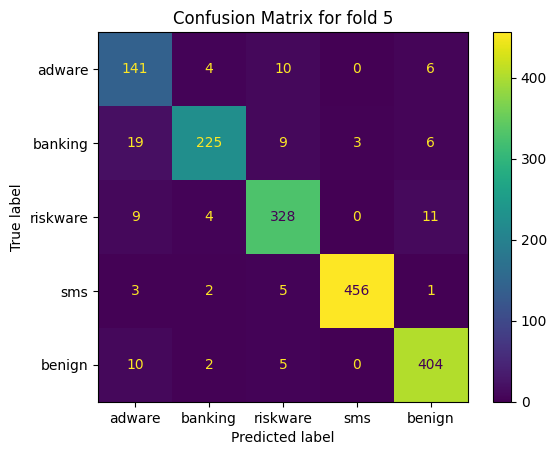

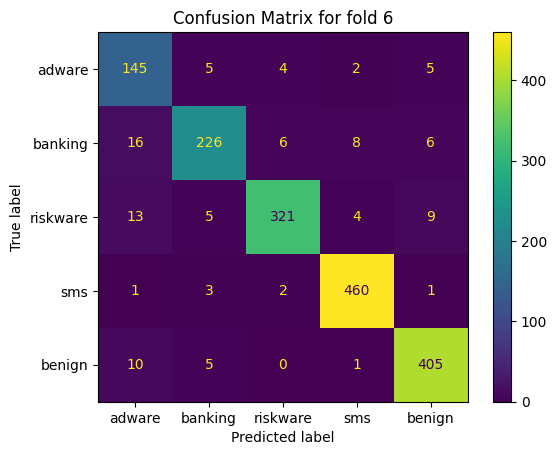

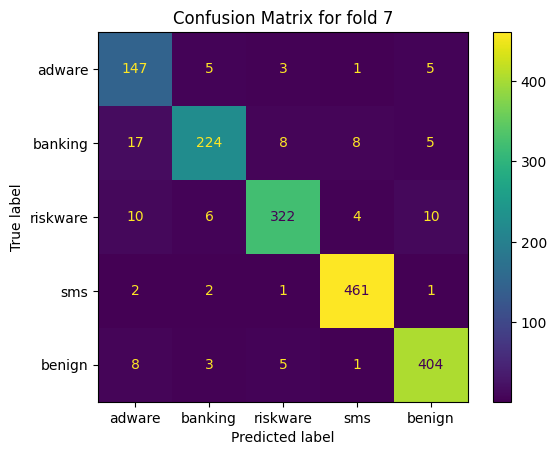

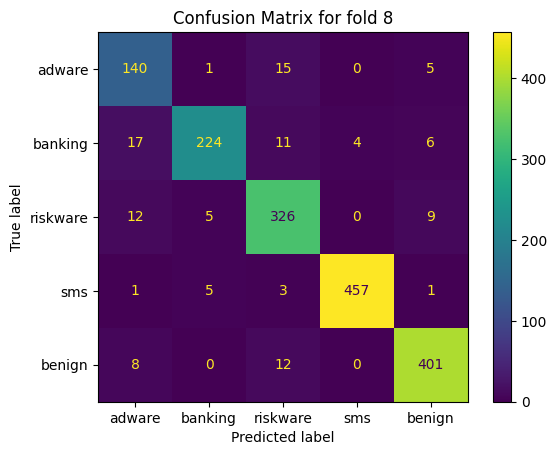

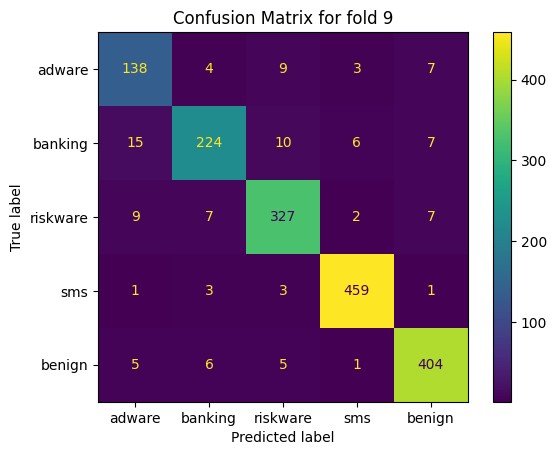

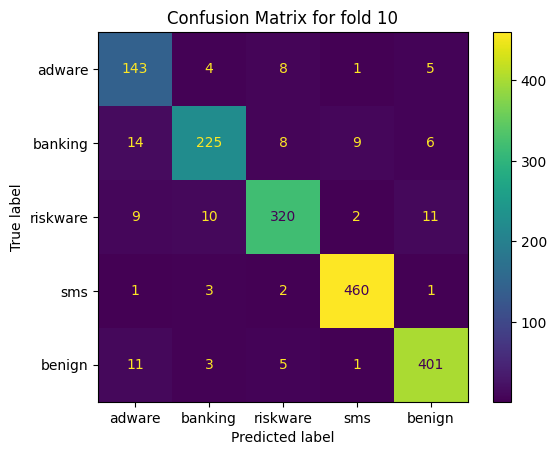

In [8]:
#classes: 0 - adware, 1 - banking, 2 - riskware, 3 - sms, 4 - benign
classes = ['adware',  'banking', 'riskware', 'sms', 'benign']

for i in range(10):
    #display confusion matrix
    fold = i+1
    cm_display = ConfusionMatrixDisplay(cm_score_per_fold[i],display_labels=classes)
    cm_display.plot()
    cm_display.ax_.set_title(f'Confusion Matrix for fold {fold}')

## GRAFICOS TEM DE SER FEITOS MANUALMENTE

In [ ]:
for i in range(10):
    train_acc = history_cv[i].history['accuracy']
    #train_loss = history_cv[i].history['loss']
    val_acc = history_cv[i].history['val_accuracy']
    #val_loss = history_cv[i].history['val_loss']

    #plot accuracy
    plt.plot(train_acc, label=f'Train acc fold{i+1}')
    plt.plot(val_acc, label=f'Val acc fold{i+1}')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
for i in range(10):
    train_acc = history_cv[i].history['accuracy']
    #train_loss = history_cv[i].history['loss']
    val_acc = history_cv[i].history['val_accuracy']
    #val_loss = history_cv[i].history['val_loss']

    #plot accuracy
    plt.plot(train_acc, label=f'Train acc fold{i+1}')
    plt.plot(val_acc, label=f'Val acc fold{i+1}')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()